In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import load_model,Model
from PIL import Image
import time
import matplotlib.pyplot as plt
import matplotlib
import requests
import base64
import os
from pathlib import Path
from io import BytesIO
matplotlib.rcParams['figure.figsize'] = (12,12)
matplotlib.rcParams['axes.grid'] = False

%load_ext autoreload
%autoreload 2

In [2]:
# Utility functions

def load_image(image_path,dim=None,resize=False):
    img= Image.open(image_path)
    if dim:
        if resize:
            img=img.resize(dim)
        else:
            img.thumbnail(dim)
    img= img.convert("RGB")
    return np.array(img)

def load_url_image(url,dim=None,resize=False):
    img_request=requests.get(url)
    img= Image.open(BytesIO(img_request.content))
    if dim:
        if resize:
            img=img.resize(dim)
        else:
            img.thumbnail(dim)
    img= img.convert("RGB")
    return np.array(img)

def array_to_img(array):
    array=np.array(array,dtype=np.uint8)
    if np.ndim(array)>3:
        assert array.shape[0]==1
        array=array[0]
    return Image.fromarray(array)

def show_image(image,title=None):
    if len(image.shape)>3:
        image=tf.squeeze(image,axis=0)
    plt.imshow(image)
    if title:
        plt.title=title
    plt.show()

def plot_images_grid(images,num_rows=1):
    n=len(images)
    if n > 1:
        num_cols=np.ceil(n/num_rows)
        fig,axes=plt.subplots(ncols=int(num_cols),nrows=int(num_rows))
        axes=axes.flatten()
        fig.set_size_inches((20,20))
        for i,image in enumerate(images):
            axes[i].axis('off')
            axes[i].imshow(image)
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(images[0])

In [3]:
# GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  0


In [4]:
# Pretrained VGG19 model to calculate perceptual loss 
vgg=vgg19.VGG19(weights='imagenet',include_top=False)
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [5]:
# Define content and style layers from pretrained model's layers
content_layers=['block4_conv2']
style_layers=['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

content_layers_weights=[1]
style_layers_weights=[1]*5

In [6]:
# Loss model to calculate perceptual loss = style loss + content loss

class LossModel:
    def __init__(self,pretrained_model,content_layers,style_layers):
        self.model=pretrained_model
        self.content_layers=content_layers
        self.style_layers=style_layers
        self.loss_model=self.get_model()

    def get_model(self):
        self.model.trainable=False
        layer_names=self.style_layers + self.content_layers
        outputs=[self.model.get_layer(name).output for name in layer_names]
        new_model=Model(inputs=self.model.input,outputs=outputs)
        return new_model
    
    def get_activations(self,inputs):
        inputs=inputs*255.0
        style_length=len(self.style_layers)
        outputs=self.loss_model(vgg19.preprocess_input(inputs))
        style_output,content_output=outputs[:style_length],outputs[style_length:]
        content_dict={name:value for name,value in zip(self.content_layers,content_output)}
        style_dict={name:value for name,value in zip(self.style_layers,style_output)}
        return {'content':content_dict,'style':style_dict}

loss_model=LossModel(vgg,content_layers,style_layers)

In [7]:
# Loss functions

def content_loss(placeholder,content,weight):
    assert placeholder.shape == content.shape
    return weight*tf.reduce_mean(tf.square(placeholder-content))

def gram_matrix(x):
    gram=tf.linalg.einsum('bijc,bijd->bcd', x, x)
    return gram/tf.cast(x.shape[1]*x.shape[2]*x.shape[3],tf.float32)

def style_loss(placeholder,style,weight):
    assert placeholder.shape == style.shape
    s=gram_matrix(style)
    p=gram_matrix(placeholder)
    return weight*tf.reduce_mean(tf.square(s-p))

def perceptual_loss(predicted_activations,content_activations,style_activations,content_weight,style_weight,content_layers_weights,style_layer_weights):
    # Content loss
    pred_content=predicted_activations["content"]
    c_loss=tf.add_n([content_loss(pred_content[name],content_activations[name],content_layers_weights[i]) for i,name in enumerate(pred_content.keys())])
    c_loss=c_loss*content_weight

    # Style loss
    pred_style=predicted_activations["style"]
    s_loss=tf.add_n([style_loss(pred_style[name],style_activations[name],style_layer_weights[i]) for i,name in enumerate(pred_style.keys())])
    s_loss=s_loss*style_weight

    return c_loss + s_loss, c_loss, s_loss

In [8]:
# Model layers

class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.padding = tuple(padding)
    def call(self, input_tensor):
        padding_width, padding_height = self.padding
        return tf.pad(input_tensor, [[0,0], [padding_height, padding_height], [padding_width, padding_width], [0,0] ], 'REFLECT')

class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
    def call(self,inputs):
        batch, rows, cols, channels = [i for i in inputs.get_shape()]
        mu, var = tf.nn.moments(inputs, [1,2], keepdims=True)
        shift = tf.Variable(tf.zeros([channels]))
        scale = tf.Variable(tf.ones([channels]))
        epsilon = 1e-3
        normalized = (inputs-mu)/tf.sqrt(var + epsilon)
        return scale * normalized + shift

class ConvLayer(tf.keras.layers.Layer):
    def __init__(self,filters,kernel_size,strides=1,**kwargs):
        super(ConvLayer,self).__init__(**kwargs)
        self.padding=ReflectionPadding2D([k//2 for k in kernel_size])
        self.conv2d=tf.keras.layers.Conv2D(filters,kernel_size,strides)
        self.bn=InstanceNormalization()
    def call(self,inputs):
        x=self.padding(inputs)
        x=self.conv2d(x)
        x=self.bn(x)
        return x

class ResidualLayer(tf.keras.layers.Layer):
    def __init__(self,filters,kernel_size,**kwargs):
        super(ResidualLayer,self).__init__(**kwargs)
        self.conv2d_1=ConvLayer(filters,kernel_size)
        self.conv2d_2=ConvLayer(filters,kernel_size)
        self.relu=tf.keras.layers.ReLU()
        self.add=tf.keras.layers.Add()
    def call(self,inputs):
        residual=inputs
        x=self.conv2d_1(inputs)
        x=self.relu(x)
        x=self.conv2d_2(x)
        x=self.add([x,residual])
        return x

class UpsampleLayer(tf.keras.layers.Layer):
    def __init__(self,filters,kernel_size,strides=1,upsample=2,**kwargs):
        super(UpsampleLayer,self).__init__(**kwargs)
        self.upsample=tf.keras.layers.UpSampling2D(size=upsample)
        self.padding=ReflectionPadding2D([k//2 for k in kernel_size])
        self.conv2d=tf.keras.layers.Conv2D(filters,kernel_size,strides)
        self.bn=InstanceNormalization()
    def call(self,inputs):
        x=self.upsample(inputs)
        x=self.padding(x)
        x=self.conv2d(x)
        return self.bn(x)

In [9]:
# Style transfer model

class StyleTransferModel(tf.keras.Model):
    def __init__(self,**kwargs):
        super(StyleTransferModel, self).__init__(name='StyleTransferModel',**kwargs)
        self.conv2d_1= ConvLayer(filters=32,kernel_size=(9,9),strides=1,name="conv2d_1_32")
        self.conv2d_2= ConvLayer(filters=64,kernel_size=(3,3),strides=2,name="conv2d_2_64")
        self.conv2d_3= ConvLayer(filters=128,kernel_size=(3,3),strides=2,name="conv2d_3_128")
        self.res_1=ResidualLayer(filters=128,kernel_size=(3,3),name="res_1_128")
        self.res_2=ResidualLayer(filters=128,kernel_size=(3,3),name="res_2_128")
        self.res_3=ResidualLayer(filters=128,kernel_size=(3,3),name="res_3_128")
        self.res_4=ResidualLayer(filters=128,kernel_size=(3,3),name="res_4_128")
        self.res_5=ResidualLayer(filters=128,kernel_size=(3,3),name="res_5_128")
        self.deconv2d_1= UpsampleLayer(filters=64,kernel_size=(3,3),name="deconv2d_1_64")
        self.deconv2d_2= UpsampleLayer(filters=32,kernel_size=(3,3),name="deconv2d_2_32")
        self.deconv2d_3= ConvLayer(filters=3,kernel_size=(9,9),strides=1,name="deconv2d_3_3")
        self.relu=tf.keras.layers.ReLU()
        
    def call(self, inputs):
        x=self.conv2d_1(inputs)
        x=self.relu(x)
        x=self.conv2d_2(x)
        x=self.relu(x)
        x=self.conv2d_3(x)
        x=self.relu(x)
        x=self.res_1(x)
        x=self.res_2(x)
        x=self.res_3(x)
        x=self.res_4(x)
        x=self.res_5(x)
        x=self.deconv2d_1(x)
        x=self.relu(x)
        x=self.deconv2d_2(x)
        x=self.relu(x)
        x=self.deconv2d_3(x)
        x = (tf.nn.tanh(x) + 1) * (255.0 / 2)
        return x
    
    ## Used to print shapes of each layer to check if input shape == output shape
    def print_shape(self,inputs):
        print(inputs.shape)
        x=self.conv2d_1(inputs)
        print(x.shape)
        x=self.relu(x)
        x=self.conv2d_2(x)
        print(x.shape)
        x=self.relu(x)
        x=self.conv2d_3(x)
        print(x.shape)
        x=self.relu(x)
        x=self.res_1(x)
        print(x.shape)
        x=self.res_2(x)
        print(x.shape)
        x=self.res_3(x)
        print(x.shape)
        x=self.res_4(x)
        print(x.shape)
        x=self.res_5(x)
        print(x.shape)
        x=self.deconv2d_1(x)
        print(x.shape)
        x=self.relu(x)
        x=self.deconv2d_2(x)
        print(x.shape)
        x=self.relu(x)
        x=self.deconv2d_3(x)
        print(x.shape)

In [10]:
# Define input shape and batch size
input_shape=(256,256,3)
# batch_size=16 # <- this bitch fat
batch_size = 4

# Create instance of style model
style_model = StyleTransferModel()
style_model.print_shape(tf.zeros(shape=(1,*input_shape)))

(1, 256, 256, 3)
(1, 256, 256, 32)
(1, 128, 128, 64)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 128, 128, 64)
(1, 256, 256, 32)
(1, 256, 256, 3)


In [11]:
# Initialize optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [12]:
# Training step

def train_step(dataset, style_activations, steps_per_epoch, style_model, loss_model, optimizer, checkpoint_path="./", content_weight=1e4, style_weight=1e-2, total_variation_weight=0.004, content_layers_weights=[1], style_layers_weights=[1]*5):
    # Batch losses after regularization
    batch_losses = []
    # Losses
    perceptual_losses = []
    content_losses = []
    style_loss = []
    
    steps = 1
    save_path=os.path.join(checkpoint_path,f"model_checkpoint.ckpt")
    print("Model Checkpoint Path: ", save_path)

    for i, input_image_batch in enumerate(dataset):
        # print(f"Hello guys, this is step [{steps}/{steps_per_epoch}]")
        if steps - 1 >= steps_per_epoch:
            break
        with tf.GradientTape() as tape:
            outputs=style_model(input_image_batch)
            outputs=tf.clip_by_value(outputs, 0, 255)
            pred_activations=loss_model.get_activations(outputs/255.0)
            content_activations=loss_model.get_activations(input_image_batch)["content"] 
            # Perceptual loss
            per_loss, content_loss, style_loss = perceptual_loss(pred_activations,content_activations,style_activations,content_weight,
                                      style_weight,content_layers_weights,style_layers_weights)
            curr_loss = per_loss + total_variation_weight * tf.image.total_variation(outputs)
        
        batch_losses.append(curr_loss) # After regularization
        perceptual_losses.append(per_loss)
        content_losses.append(content_loss)
        style_losses.append(style_loss)

        grad = tape.gradient(curr_loss,style_model.trainable_variables)
        optimizer.apply_gradients(zip(grad,style_model.trainable_variables))

        if steps % 100 == 0:
            print("checkpoint saved ", end = " ")
            style_model.save_weights(save_path)

            bl = tf.reduce_mean(batch_losses).numpy()
            pl = tf.reduce_mean(perceptual_losses).numpy()
            cl = tf.reduce_mean(content_losses).numpy()
            sl = tf.reduce_mean(style_losses).numpy()

            print(f"Loss: {bl}") 
            print(f"Perceptual Loss: {pl}")
            print(f"Content Loss: {cl}")
            print(f"Style Loss: {sl}")

            f.write(f'Epoch [{epoch_idx}/{epochs}] Step [{steps}]\t Batch loss: [{bl:.4f}]\t Perceptual: [{pl:.4f}]\t Content: [{cl:.4f}]\t Style: [{sl:.4f}]\n')
            f.flush()

        steps+=1

    return tf.reduce_mean(batch_losses), tf.reduce_mean(perceptual_losses), tf.reduce_mean(content_losses), tf.reduce_mean(style_losses)

In [13]:
class TensorflowDatasetLoader:
    def __init__(self,dataset_path,batch_size=4, image_size=(256, 256),num_images=None):
        images_paths = [str(path) for path in Path(dataset_path).glob("*.jpg")]
        self.length=len(images_paths)
        if num_images is not None:
            images_paths = images_paths[0:num_images]
        dataset = tf.data.Dataset.from_tensor_slices(images_paths).map(
            lambda path: self.load_tf_image(path, dim=image_size),
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
        dataset = dataset.batch(batch_size,drop_remainder=True)
        dataset = dataset.repeat()
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        self.dataset=dataset

    def __len__(self):
        return self.length

    def load_tf_image(self,image_path,dim):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image,dim)
        image = image/255.0
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image

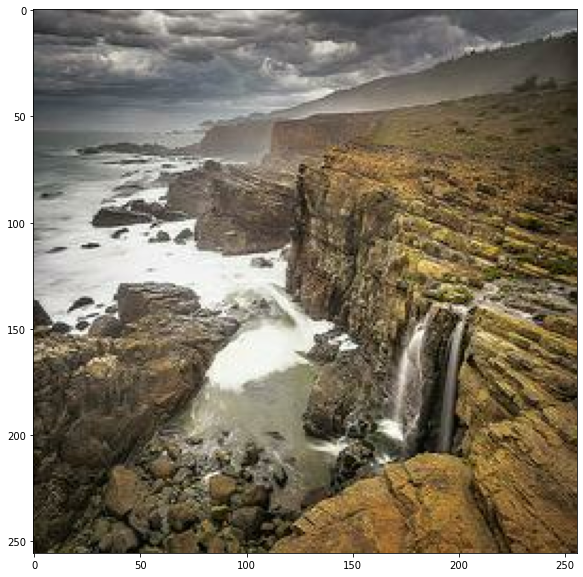

In [14]:
# Load dataset
input_path = "../../data/photo"
style_path = "../../data/monet"

# Photograph dataset
loader = TensorflowDatasetLoader(input_path, batch_size=batch_size)
loader.dataset.element_spec
plot_images_grid(next(iter(loader.dataset.take(1))),num_rows=4)

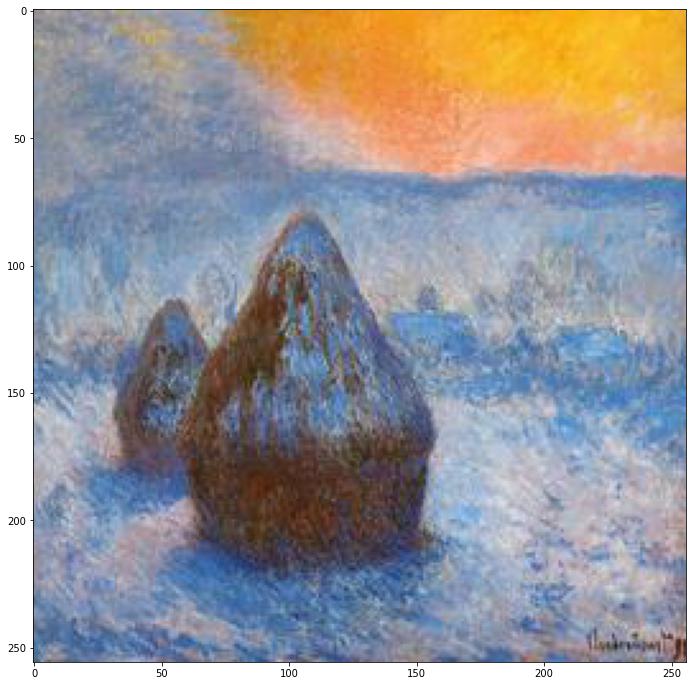

In [15]:
# Set up style image dataset for training
style_image_path = os.path.join(style_path,"3417ace946.jpg")
style_image = load_image(style_image_path,dim=(input_shape[0],input_shape[1]),resize=True)
style_image = style_image/255.0

# Show image
show_image(style_image)

style_image = style_image.astype(np.float32)
style_image_batch = np.repeat([style_image],batch_size,axis=0)
style_activations = loss_model.get_activations(style_image_batch)["style"]

In [16]:
# Training style model 
# epochs = 10
epochs = 125
content_weight = 2*1e1
style_weight = 1e2
total_variation_weight = 0.004

num_images = len(loader)
steps_per_epochs = num_images//batch_size
print(steps_per_epochs)

7038


In [17]:
model_save_path = "model_checkpoint"
os.makedirs(model_save_path,exist_ok=True)

In [18]:
# Enable mix precision and jit for training optimization
try:
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.keras.mixed_precision.experimental.set_policy(policy) 
except:
    pass

try:
    tf.config.optimizer.set_jit(True)
except:
    pass

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [19]:
# Load previous saved checkpoints if exists
if os.path.isfile(os.path.join(model_save_path,"model_checkpoint.ckpt.index")):
    style_model.load_weights(os.path.join(model_save_path,"model_checkpoint.ckpt"))
    print("resuming training ...")
else:
    print("training scratch ...")

training scratch ...


In [20]:
# Train + write losses to log file
f = open("./losses.txt", "a")
f.write("Losses log for VGG19\n")

# Epoch losses
epoch_losses = []
perceptual_losses = []
content_losses = []
style_losses = []

for epoch in range(1,epochs+1):
    print(f"epoch: {epoch}")
    batch_loss, perceptual_loss, content_loss, style_loss = train_step(loader.dataset,
                                                                        style_activations,
                                                                        steps_per_epochs,
                                                                        style_model,
                                                                        loss_model,optimizer,
                                                                        model_save_path,
                                                                        content_weight,
                                                                        style_weight,
                                                                        total_variation_weight,
                                                                        content_layers_weights,
                                                                        style_layers_weights)
    style_model.save_weights(os.path.join(model_save_path,"model_checkpoint.ckpt"))
    print("Model Checkpointed at: ",os.path.join(model_save_path,"model_checkpoint.ckpt"))
    
    epoch_losses.append(batch_loss)
    perceptual_losses.append(perceptual_loss)
    content_losses.append(content_loss)
    style_losses.append(style_loss)

    # Print and write losses to file
    bl = epoch_losses.numpy()
    pl = perceptual_losses.numpy()
    cl = content_losses.numpy()
    sl = style_losses.numpy()

    f_string = f'EPOCH [{epoch}/{epochs+1}]\t Batch loss: {bl:.4f}\t Perceptual: {pl:.4f}\t Content: {cl:.4f}\t Style: {sl:.4f}\n\n'
    print(f_string)
    f.write(f_string)
    f.flush()

f.close()

epoch: 1
Model Checkpoint Path:  model_checkpoint/model_checkpoint.ckpt
Hello guys, this is step [1/7038]
Hello guys, this is step [2/7038]
Hello guys, this is step [3/7038]
Hello guys, this is step [4/7038]
Hello guys, this is step [5/7038]
Hello guys, this is step [6/7038]
Hello guys, this is step [7/7038]


KeyboardInterrupt: 

In [ ]:
# Plot losses
plt.plot(epoch_losses)
plt.plot(perceptual_losses)
plt.plot(content_losses)
plt.plot(style_losses)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Process")
plt.show()

In [ ]:
# Generate artworks
styled_images = []

for images in loader.dataset.take(1):
    images = images * 255.0
    generated_images = style_model(images)
    generated_images = np.clip(generated_images,0,255)
    generated_images = generated_images.astype(np.uint8)
    for image in generated_images:
        styled_images.append(image)

In [ ]:
# Plot original photographs
plot_images_grid(next(iter(loader.dataset.take(1))),num_rows = 4)

In [ ]:
# Plot styled images
plot_images_grid(styled_images,num_rows = 4)

In [ ]:
# Save results
# TODO: Make file name the same as original photograph for easier comparison 
os.makedirs('./results',exist_ok=True)

i = 1
for images in loader.dataset.take(500):
    images = images * 255.0
    generated_images = style_model(images)
    generated_images = np.clip(generated_images,0,255)
    generated_images = generated_images.astype(np.uint8)
    for image in generated_images:
        img = Image.fromarray(image)
        img.save(os.path.join('./results',f'{i}.jpg'))
        i = i + 1
